In [16]:
import os
import numpy as np
import torch
import pandas as pd
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, periodogram
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from torch.utils.data import random_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gc
from sklearn.metrics import r2_score
from scipy.io import savemat
import joblib
from scipy.signal import hilbert
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


In [ ]:
# Noise Filters
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=1.0, highcut=200.0, fs=1000.0, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

# Apply after bandpass
def notch_filter(data, freq=60.0, fs=1000.0, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, data, axis=0)

# Noise Metrics for evaluation
def compute_rmse(true, estimate):
    return np.sqrt(np.mean((true - estimate) ** 2))

# Kurtosis signal reduction > 0 shows a denoised signal
def proportion_of_positive_kurtosis_signals(kurtosis_raw, kurtosis_denoised):
    return (np.array([(kurtosis_raw - kurtosis_denoised) > 0]).sum() / len(kurtosis_raw)) * 100

# Use a Standard scaler to reduce the mean to 0 and std to 1

In [15]:
# Computing the power envelope of each channel

def band_power_envelope(ecog_signal: np.ndarray, lowcut: float, highcut: float, fs: float = 1000.0, order: int = 4) -> np.ndarray:
    """Computes band-limited envelope via Hilbert transform.
    Parameters
    ----------
    self.ecog_signal : np.ndarray (T, channels)
        This is the ecog signal that has been filtered.
    lowcut : float
        This is the lower band limit in Hz.
    highcut : float
        This is the upper band limit in Hz.
    fs : float, optional
        This is the frequency of the sample., by default 1000.0
    order : int, optional
        This is the Butterworth order, by default 4
    Returns
    -------
    np.ndarray
        envelope
    """
    # 1. Narrowband bandpass
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    narrow = filtfilt(b, a, ecog_signal, axis=0)
    # 2. Hilbert transform to get analytic signal
    analytic = hilbert(narrow, axis=0)
    # 3. Envelope = absolute value
    envelope = np.abs(analytic)
    return envelope

def multiband_features(ecog_raw: np.ndarray, fs: float = 1000.0) -> np.ndarray:
    """Builds concatenated band-power features for μ, β, and high-gamma.
    Parameters
    ----------
    ecog_raw : np.ndarray
        (T, 64)
    fs : float, optional
        Frequency of the sample, by default 1000.0
    Returns
    -------
    np.ndarray
        features: (T, 64, 3) (μ, β, high-gamma per electrode)
    """
    mu_env = band_power_envelope(ecog_raw, lowcut=8.0, highcut=13.0, fs=fs)
    beta_env = band_power_envelope(ecog_raw, lowcut=13.0, highcut=30.0, fs=fs)
    hg_env = band_power_envelope(ecog_raw, lowcut=70.0, highcut=200.0, fs=fs)
    # Concatenate along channel dimension
    return np.concatenate([mu_env, beta_env, hg_env], axis=1)


In [19]:
def create_overlapping_windows(ecog_values: np.ndarray, motion_values: np.ndarray, window_size: int = 20, hop_size: int = 10):
    """Builds overlapping windows to increase sample count and capture smoother transitions.

    Parameters
    ----------
    ecog_values : np.ndarray
        (T, features)
    motion_values : np.ndarray
        (T_motion, 3)_
    window_size : int, optional
        number of timepoints per window, by default 20
    hop_size : int, optional
        step bewteen windows, by default 10
    """
    num_samples, num_features = ecog_values.shape
    max_windows = (num_samples - window_size) // hop_size + 1
    X_list = []
    y_list = []
    for w in range(max_windows):
        start = w * hop_size
        end = start + window_size
        if end > num_samples:
            break
        # Assign label as motion at center of window (or last timepoint)
        X_list.append(ecog_values[start:end, :])
        y_list.append(motion_values[min(end -1, motion_values.shape[0] -1), :])
    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y        


In [ ]:
# Model definitions
class EcogMotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# CNN/LSTM hybrid
class EcogToMotionNet(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN component: outputs 256 channels
        self.convolv = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # Fixed to 256 channels
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3)
        )

        # Bi-LSTM component (2 Layers)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        self.attn_weight = nn.Linear(2 * 128, 1, bias=False)

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(2*128, 3)  # Matches hidden_size=128
        )

    def forward(self, x):
        # Input shape: (batch, 20, 64)
        x = x.permute(0, 2, 1)  # Shape: (batch, 64, 20)
        x = self.convolv(x)      # Shape: (batch, 256, 20)
        x = x.permute(0, 2, 1)   # Shape: (batch, 20, 256)

        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out shape: (batch, 20, 128)

        # Compute attention scores
        # Flatten across features: attn_score[i, t] = wT * h_{i, t}
        # Then softmax over t to get α_{i, t}
        attn_scores = self.attn_weight(lstm_out).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        # Weighted sum of LSTM outputs:
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)

        # Regression to 3D motion
        output = self.fc(attn_applied)
        return output

# Linear Model
class LinearEcogToMotionNet(nn.Module):
    def __init__(self, input_channels = 64, sequence_length = 20, output_dim = 3):
        super().__init__()
        self.linear = nn.Linear(input_channels * sequence_length, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = x.flatten(start_dim=1)
        x = self.linear(x)
        return x

# LSTM
class EcogLSTM(nn.Module):
    def __init__(self, input_size = 64, hidden_size = 128, num_layers = 1, output_size = 3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x) # lstm_out shape: (batch_size, seq_len, hidden_size)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output
 

In [20]:
class PreprocessData:
    def __init__(self, ecog_file_path, motion_file_path):
        self.ecog_file_path = ecog_file_path
        self.motion_file_path = motion_file_path
        self.ecog_data = None
        self.motion_data = None
        self.filtered_ecog = None
        self.scaled_ecog = None
        self.X = None
        self.y = None
        self.scaler = None

    def process(self, eval=False, window_size=20, duration_limit=900):
        self.read_data()
        self.common_average_reference()
        self.filter_signal(eval=eval)
        self.format_data(window_size=window_size, duration_limit=duration_limit)
        return self.X, self.y
    
    def read_data(self):
        self.ecog_data = pd.read_csv(self.ecog_file_path)
        self.motion_data = pd.read_csv(self.motion_file_path)
        return self

    def common_average_reference(self):
        # Subtract the common mean from the signals 
        self.ecog_data -= np.mean(self.ecog_data, axis=1, keepdims=True)
        return self

    def filter_signal(self, eval=False):
        ecog_raw = self.ecog_data[self.ecog_data.columns[1:-1]].values

        # Apply filters
        filtered = bandpass_filter(ecog_raw, lowcut=1.0, highcut=200.0, fs=1000.0, order=4)
        denoised = notch_filter(filtered, freq=60, fs=1000.0)

        # Evaluate filters
        if eval:
            kurt_raw = kurtosis(ecog_raw, axis=0, fisher=True)
            kurt_denoised = kurtosis(denoised, axis=0, fisher=True)
            proportion_of_positive_kurtosis_signals(kurt_raw, kurt_denoised)
            compute_rmse(ecog_raw, denoised)

        # Compute Power Envelopes
        features = multiband_features(denoised, fs=1000.0) # shape (T, 192)

        # Identify the principal components of the network
        pca = PCA(n_componens = 64, random_state=42)
        reduced = pca.fit_transform(features)

        # Scale
        self.scaler = StandardScaler()
        self.scaled_ecog = self.scaler.fit_transform(reduced)

        # Replace in DataFrame
        self.ecog_data = self.ecog_data.copy()
        self.ecog_data[self.ecog_data.columns[1:-1]] = self.scaled_ecog

        # Clean memory
        del ecog_raw, filtered, denoised
        gc.collect()
        return self

    def format_data(self, window_size=20, duration_limit=900):
        ecog_df = self.ecog_data[self.ecog_data["Time"] <= duration_limit]
        motion_df = self.motion_data[self.motion_data["Motion_time"] <= duration_limit]

        ecog_values = ecog_df[ecog_df.columns[1:-1]].values
        motion_values = motion_df[motion_df.columns[2:]].values

        X, y = create_overlapping_windows(ecog_values, motion_values, window_size=20, hop_size=10)
        self.X, self.y = X, y
        
        # num_windows = motion_values.shape[0]

        # # Create sliding windows
        # self.X = np.stack([
        #     ecog_values[i*window_size:(i+1)*window_size]
        #     for i in range(num_windows)
        # ])
        # self.y = motion_values[:num_windows]
        print(self.X.shape)
        print(self.y.shape)    
        
        # Clean up
        del ecog_values, motion_values
        gc.collect()

    def save(self):
        output_file_path_base = self.ecog_file_path.strip("ecog_data.csv")
        joblib.dump(self.scaler, output_file_path_base + "scaler_ecog.pkl")
        np.save(output_file_path_base + "X.npy", self.X)
        np.save(output_file_path_base + "y.npy", self.y)


In [26]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, device, epochs=20, model_name="model"):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 10 # epochs
    
    train_losses = []
    val_losses = []
    r2_scores = []
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X_batch.size(0)
        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validate
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)
                all_preds.append(preds.cpu())
                all_targets.append(y_batch.cpu())
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()
        r2 = r2_score(all_targets, all_preds)
        r2_scores.append(r2)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)
        
        print(f"{model_name} Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | R2: {r2:.6f}")
        

        # Save best model checkpoint
        if avg_val_loss < best_val_loss - 1e-5:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            print(f"Model Checkpoint | epoch: {epoch} | best_val_loss: {best_val_loss}")
            torch.save(model.state_dict(), "best_ecog_model.pth")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    return train_losses, val_losses

def plot_losses(losses_dict):
    plt.figure(figsize=(10,6))
    for model_name, (train_losses, val_losses) in losses_dict.items():
        plt.plot(train_losses, label=f"{model_name} Train")
        plt.plot(val_losses, label=f"{model_name} Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
os.path.join(os.getcwd(), "src/", "motor_cortex/data/")

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/'

In [8]:
motion_data_file_l = glob(os.path.join(os.getcwd(), "src/", "motor_cortex/data/data/", "**", "motion*.csv"), recursive=True)
ecog_data_file_l = glob(os.path.join(os.getcwd(), "src/", "motor_cortex/data/data/", "**", "ecog*.csv"), recursive=True)

# Reading only the Right Wrist data and training to detect depending on the Right Wrist

## Bilateral Data

In [ ]:
motion_data_file_l[0]

In [ ]:
motion_data_file = motion_data_file_l[0]

In [ ]:
ecog_data_file = ecog_data_file_l[0]

In [ ]:
motion_data_file

In [ ]:
ecog_data_file

In [ ]:
motion_data_bilateral_2018_07_12_S1 = pd.read_csv(motion_data_file)

In [ ]:
motion_data_bilateral_2018_07_12_S1["Motion_time"]

In [ ]:
ecog_data_bilateral_2018_07_12_S1 = pd.read_csv(ecog_data_file)
channel_data = ecog_data_bilateral_2018_07_12_S1.columns[1:-1].values
ecog_data_bilateral_2018_07_12_S1[channel_data].values

In [ ]:
ecog_data_bilateral_2018_07_12_S1["Time"]

In [ ]:
plt.plot(ecog_data_bilateral_2018_07_12_S1["Time"], ecog_data_bilateral_2018_07_12_S1[channel_data].values)

In [ ]:
ecog_channels = ecog_data_bilateral_2018_07_12_S1.columns[1:-1]

In [ ]:
ecog_data_bilateral_2018_07_12_S1[ecog_channels].values

In [ ]:
motion_data_bilateral_2018_07_12_S1_left_wrist = motion_data_bilateral_2018_07_12_S1[motion_data_bilateral_2018_07_12_S1.columns[1:4]]

In [ ]:
motion_data_bilateral_2018_07_12_S1_left_wrist

In [ ]:
motion_data_bilateral_2018_07_12_S1_left_wrist

In [ ]:
ecog_data_bilateral_2018_07_12_S1[channel_data]

In [ ]:
del ecog_data_bilateral_2018_07_12_S1

## Ipsilateral Data (Right Wrist)

In [ ]:
ecog_data_file_l[8]

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/ecog_data.csv'

In [ ]:
ecog_data_file_l[8]

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/ecog_data.csv'

In [69]:
current_ecog_data_file = ecog_data_file_l[8]
current_motion_data_file = motion_data_file_l[8]
preprocessor = PreprocessData(current_ecog_data_file, current_motion_data_file)
X, y = preprocessor.process()
preprocessor.save()

(920498, 64)
(44982, 20, 64)
(44982, 3)


In [ ]:
# Preprocess Ipsilateral Data
# for index in range(6, 16):
#     preprocessor = PreprocessData(ecog_data_file_l[index], motion_data_file_l[index])
#     X, y = preprocessor.process()
#     preprocessor.save()

KeyboardInterrupt: 

In [11]:
ecog_data_file_l[16:ecog_data_file_l.__len__()]

['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-03-15_(S1)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-12_(S3)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-08_(S2)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-22_(S7)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-12_(S4)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-22_(S9)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-12_(S5)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-22_(S8)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-05-31_(S10)/ecog_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Contralateral/2018-04-15_(S6)/ecog_data.csv']

In [ ]:
# # Preprocess Contralateral Data
# for index in range(16, ecog_data_file_l.__len__()):
#     preprocessor = PreprocessData(ecog_data_file_l[index], motion_data_file_l[index])
#     X, y = preprocessor.process()
#     preprocessor.save()

In [8]:
# Read in the data
processed_data_l_X = glob(os.path.join('/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/', '**', "**", "X.npy"))
processed_data_l_y = glob(os.path.join('/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/', '**', "**", "y.npy"))

In [9]:
processed_data_l_X

['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S7)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-06_(S6)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S5)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S3)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S4)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S8)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-17_(S9)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S2)/X.npy']

In [10]:
processed_data_l_y

['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S7)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-06_(S6)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S5)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S3)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S4)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S8)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-17_(S9)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S2)/y.npy']

In [87]:
# # Perform K-Fold Cross Validation
# iterator = iter(processed_data_l)

# for X, y in zip(iterator, iterator):
#     print(X)
#     print(y)

# Create k-fold cross validation
# select the best model
# make a prediction
# visualize the predictions in matlab
# create a live demo
# deploy demo onto the web
# share results for testing with real people


In [33]:
# Define K-fold sets
test_list_X = []
train_list_X = []
test_list_y = []
train_list_y = []

for i in range(len(processed_data_l_X)):
    test_list_X.append(processed_data_l_X[i])
    test_list_y.append(processed_data_l_y[i])
    train_X = [x for idx, x in enumerate(processed_data_l_X) if idx != i]
    train_y = [y for idx, y in enumerate(processed_data_l_y) if idx != i]
    train_list_X.append(train_X)
    train_list_y.append(train_y)

In [16]:
INDEX = 0

In [ ]:
X = np.load(train_list_X[INDEX][0])
y = np.load(train_list_y[INDEX][0])

In [42]:
train_list_X

[['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-06_(S6)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S5)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S3)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S4)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S8)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-17_(S9)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S2)/X.npy'],
 ['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S7)/X.npy',
  '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/X.npy',
  '/home

In [44]:
train_list_y[0]

['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-06_(S6)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S5)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S3)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S4)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S8)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-17_(S9)/y.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S2)/y.npy']

In [18]:
X.shape

(44989, 20, 64)

In [19]:
y.shape

(44989, 3)

In [20]:
# Creating Train and Validation Sets
dataset = EcogMotionDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [21]:
# Defining the model

# Train Linear Model
input_channels = X.shape[2]
sequence_length = X.shape[1]
model = LinearEcogToMotionNet(input_channels, sequence_length)

# Train 1D CNN
# model = EcogToMotionNet()

# Train LSTM
# model = EcogLSTM(input_size=64, hidden_size=128, num_layers=1, output_size=3)


## Linear Model

In [118]:
# Linear Model 

# Train Linear Model
input_channels = X.shape[2]
sequence_length = X.shape[1]
linear_model = LinearEcogToMotionNet(input_channels, sequence_length)

linear_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    linear_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = linear_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    linear_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = linear_model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val.Loss: {val_loss:.4f}")

Epoch 1 | Train Loss: 1.0769 | Val.Loss: 1.0425
Epoch 2 | Train Loss: 1.0670 | Val.Loss: 1.0912
Epoch 3 | Train Loss: 1.0628 | Val.Loss: 1.0493
Epoch 4 | Train Loss: 1.0661 | Val.Loss: 1.0837
Epoch 5 | Train Loss: 1.0581 | Val.Loss: 1.0499
Epoch 6 | Train Loss: 1.0566 | Val.Loss: 1.1074
Epoch 7 | Train Loss: 1.0686 | Val.Loss: 1.0719
Epoch 8 | Train Loss: 1.0677 | Val.Loss: 1.0536
Epoch 9 | Train Loss: 1.0560 | Val.Loss: 1.0878
Epoch 10 | Train Loss: 1.0602 | Val.Loss: 1.0627
Epoch 11 | Train Loss: 1.0574 | Val.Loss: 1.0796
Epoch 12 | Train Loss: 1.0553 | Val.Loss: 1.0486
Epoch 13 | Train Loss: 1.0602 | Val.Loss: 1.0814
Epoch 14 | Train Loss: 1.0547 | Val.Loss: 1.0619
Epoch 15 | Train Loss: 1.0564 | Val.Loss: 1.0507
Epoch 16 | Train Loss: 1.0573 | Val.Loss: 1.0746
Epoch 17 | Train Loss: 1.0554 | Val.Loss: 1.1448
Epoch 18 | Train Loss: 1.0580 | Val.Loss: 1.0960
Epoch 19 | Train Loss: 1.0553 | Val.Loss: 1.1393
Epoch 20 | Train Loss: 1.0613 | Val.Loss: 1.0804


## Convolutional Neural Network

In [18]:
# Train 1D CNN
cnn_model = EcogToMotionNet()

cnn_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    cnn_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = cnn_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    cnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = cnn_model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val.Loss: {val_loss:.4f}")

Epoch 1 | Train Loss: 0.9920 | Val.Loss: 0.2579
Epoch 2 | Train Loss: 0.9682 | Val.Loss: 0.2520
Epoch 3 | Train Loss: 0.9553 | Val.Loss: 0.2561
Epoch 4 | Train Loss: 0.9446 | Val.Loss: 0.2527
Epoch 5 | Train Loss: 0.9353 | Val.Loss: 0.2450
Epoch 6 | Train Loss: 0.9261 | Val.Loss: 0.2440
Epoch 7 | Train Loss: 0.9204 | Val.Loss: 0.2439
Epoch 8 | Train Loss: 0.9123 | Val.Loss: 0.2433
Epoch 9 | Train Loss: 0.9097 | Val.Loss: 0.2416
Epoch 10 | Train Loss: 0.9020 | Val.Loss: 0.2387
Epoch 11 | Train Loss: 0.8989 | Val.Loss: 0.2417
Epoch 12 | Train Loss: 0.8953 | Val.Loss: 0.2400
Epoch 13 | Train Loss: 0.8896 | Val.Loss: 0.2375
Epoch 14 | Train Loss: 0.8870 | Val.Loss: 0.2445
Epoch 15 | Train Loss: 0.8855 | Val.Loss: 0.2390
Epoch 16 | Train Loss: 0.8832 | Val.Loss: 0.2387
Epoch 17 | Train Loss: 0.8792 | Val.Loss: 0.2378
Epoch 18 | Train Loss: 0.8747 | Val.Loss: 0.2372
Epoch 19 | Train Loss: 0.8728 | Val.Loss: 0.2359
Epoch 20 | Train Loss: 0.8715 | Val.Loss: 0.2355


## Long Short-Term Memory Model

In [207]:
lstm_model = EcogLSTM(input_size=64, hidden_size=128, num_layers=1, output_size=3)
lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    lstm_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = lstm_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    lstm_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = lstm_model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val.Loss: {val_loss:.4f}")

Epoch 1 | Train Loss: 1.0020 | Val.Loss: 0.9884
Epoch 2 | Train Loss: 0.9697 | Val.Loss: 0.9664
Epoch 3 | Train Loss: 0.9395 | Val.Loss: 0.9427
Epoch 4 | Train Loss: 0.9096 | Val.Loss: 0.9568
Epoch 5 | Train Loss: 0.8788 | Val.Loss: 0.9366
Epoch 6 | Train Loss: 0.8429 | Val.Loss: 0.9287
Epoch 7 | Train Loss: 0.8062 | Val.Loss: 0.9435
Epoch 8 | Train Loss: 0.7639 | Val.Loss: 0.9770
Epoch 9 | Train Loss: 0.7134 | Val.Loss: 0.9351
Epoch 10 | Train Loss: 0.6753 | Val.Loss: 0.9574
Epoch 11 | Train Loss: 0.6273 | Val.Loss: 0.9840
Epoch 12 | Train Loss: 0.5923 | Val.Loss: 0.9928
Epoch 13 | Train Loss: 0.5456 | Val.Loss: 0.9715
Epoch 14 | Train Loss: 0.5127 | Val.Loss: 0.9826
Epoch 15 | Train Loss: 0.4877 | Val.Loss: 1.0007
Epoch 16 | Train Loss: 0.4565 | Val.Loss: 1.0444
Epoch 17 | Train Loss: 0.4305 | Val.Loss: 1.0313
Epoch 18 | Train Loss: 0.4180 | Val.Loss: 1.0267
Epoch 19 | Train Loss: 0.3837 | Val.Loss: 1.0373
Epoch 20 | Train Loss: 0.3853 | Val.Loss: 1.0555


## Training All Models

In [46]:
train_list_X[0]

['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-06_(S6)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S5)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S3)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S4)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S8)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-17_(S9)/X.npy',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S2)/X.npy']

In [16]:
test_list_X[0]

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S7)/X.npy'

CNN Epoch 1/100 | Train Loss: 0.785687 | Val Loss: 0.722110 | R2: 0.299836
Model Checkpoint | epoch: 0 | best_val_loss: 0.7221096145111874
CNN Epoch 2/100 | Train Loss: 0.714089 | Val Loss: 0.684323 | R2: 0.336406
Model Checkpoint | epoch: 1 | best_val_loss: 0.6843227788148581
CNN Epoch 3/100 | Train Loss: 0.689621 | Val Loss: 0.702854 | R2: 0.318372
CNN Epoch 4/100 | Train Loss: 0.668353 | Val Loss: 0.694770 | R2: 0.326342
CNN Epoch 5/100 | Train Loss: 0.658022 | Val Loss: 0.675320 | R2: 0.345082
Model Checkpoint | epoch: 4 | best_val_loss: 0.6753198531670416
CNN Epoch 6/100 | Train Loss: 0.654197 | Val Loss: 0.650865 | R2: 0.368813
Model Checkpoint | epoch: 5 | best_val_loss: 0.6508649142467521
CNN Epoch 7/100 | Train Loss: 0.640321 | Val Loss: 0.645442 | R2: 0.374132
Model Checkpoint | epoch: 6 | best_val_loss: 0.6454422133659599
CNN Epoch 8/100 | Train Loss: 0.630975 | Val Loss: 0.633905 | R2: 0.385319
Model Checkpoint | epoch: 7 | best_val_loss: 0.6339045615378506
CNN Epoch 9/100 

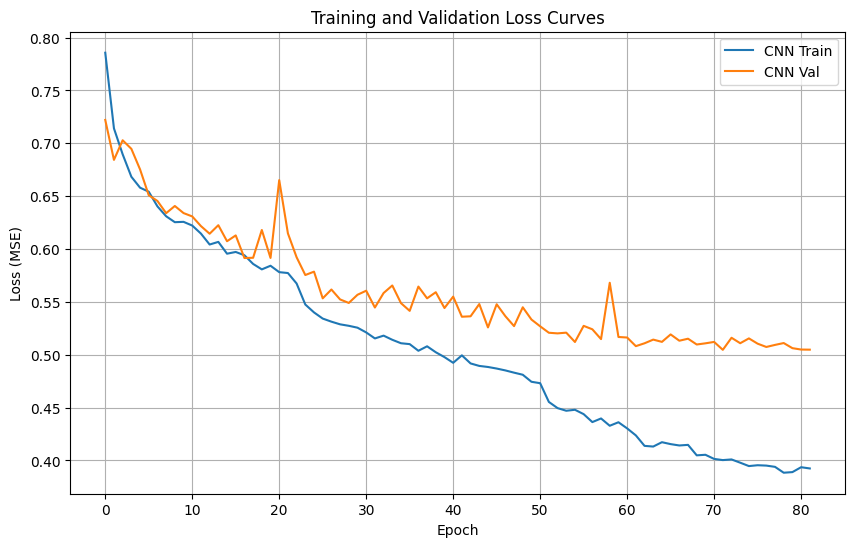

In [27]:
# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Training and Test data
# Read in the data
processed_data_l_X = glob(os.path.join('/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/', '**', "**", "X.npy"))
processed_data_l_y = glob(os.path.join('/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/', '**', "**", "y.npy"))
# Define K-fold sets
test_list_X = []
train_list_X = []
test_list_y = []
train_list_y = []

for i in range(len(processed_data_l_X)):
    test_list_X.append(processed_data_l_X[i])
    test_list_y.append(processed_data_l_y[i])
    train_X = [x for idx, x in enumerate(processed_data_l_X) if idx != i]
    train_y = [y for idx, y in enumerate(processed_data_l_y) if idx != i]
    train_list_X.append(train_X)
    train_list_y.append(train_y)


# Load a single specific dataset
# K-Fold 0 uses session 7 as the test set:
KFOLD = 0
SESSION_SET = 6

"""
['/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/X.npy', 0
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/X.npy', 1
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-06_(S6)/X.npy', 2
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S5)/X.npy', 3
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S3)/X.npy', 4
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-03_(S4)/X.npy', 5
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-10_(S8)/X.npy', 6 
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-17_(S9)/X.npy', 7
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S2)/X.npy'] 8
"""

X = np.load(train_list_X[KFOLD][SESSION_SET])
y = np.load(train_list_y[KFOLD][SESSION_SET])

# X = np.load(test_list_X[0]) # Identify the test set
# y = np.load(test_list_y[0]) # Identify the test set

# Creating Train and Validation Sets
dataset = EcogMotionDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Assuming train_loader, val_loader, criterion are defined

# 1. LSTM
# lstm_model = EcogLSTM(input_size=64, hidden_size=128, num_layers=1, output_size=3)
# lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
# lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, criterion, lstm_optimizer, device, epochs=20, model_name="LSTM")

# 2. CNN
cnn_model = EcogToMotionNet()
criterion = nn.MSELoss()
cnn_train_losses, cnn_val_losses = train_model(cnn_model, train_loader, val_loader,device, epochs=100, model_name="CNN")

# 3. Linear
# input_channels = X.shape[2]
# sequence_length = X.shape[1]
# linear_model = LinearEcogToMotionNet(input_channels, sequence_length)
# linear_optimizer = torch.optim.Adam(linear_model.parameters(), lr=1e-3)
# linear_train_losses, linear_val_losses = train_model(linear_model, train_loader, val_loader, criterion, linear_optimizer, device, epochs=20, model_name="Linear")

# Plot all losses together
plot_losses({
    # "LSTM": (lstm_train_losses, lstm_val_losses),
    "CNN": (cnn_train_losses, cnn_val_losses),
    # "Linear": (linear_train_losses, linear_val_losses)
})



## Loading the model and making predictions

In [2]:
# Recreate the model structure
cnn_model = EcogToMotionNet()
cnn_model.load_state_dict(torch.load("Hybrid_best_model_session_8_ipsilateral_2018_05_10.pth"))
cnn_model.to(device)
cnn_model.eval()

NameError: name 'EcogToMotionNet' is not defined

In [21]:
# Define K-fold sets
test_list_X = []
train_list_X = []
test_list_y = []
train_list_y = []

for i in range(len(processed_data_l_X)):
    test_list_X.append(processed_data_l_X[i])
    test_list_y.append(processed_data_l_y[i])
    train_X = [x for idx, x in enumerate(processed_data_l_X) if idx != i]
    train_y = [y for idx, y in enumerate(processed_data_l_y) if idx != i]
    train_list_X.append(train_X)
    train_list_y.append(train_y)

In [22]:
test_list_X[1]

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/X.npy'

In [38]:
test_list_y[1]

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-05-24_(S10)/y.npy'

In [63]:
train_list_X[0][1]

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/data/Ipsilateral/2018-04-29_(S1)/X.npy'

In [ ]:
# Trained on the 8th session and predicting on the first session

In [70]:
current_ecog_data_file = ecog_data_file_l[8]
current_motion_data_file = motion_data_file_l[8]
preprocessor = PreprocessData(current_ecog_data_file, current_motion_data_file)
X, y = preprocessor.process()
preprocessor.save()

(920498, 64)
(44982, 20, 64)
(44982, 3)


In [71]:
# Trained using data from session 8; Testing using data from session 1
X = np.load(train_list_X[0][1])
y = np.load(train_list_y[0][1])
scaler = joblib.load(train_list_X[0][1].strip("X.npy") + "scaler_ecog.pkl")

In [ ]:
# Creating Train and Validation Sets
dataset = EcogMotionDataset(X, y)
test_loader = DataLoader(dataset, batch_size=64, shuffle = True)

In [75]:
def predict_and_export(model, data_loader, device, output_file_path):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # Save as .mat file for visualization
    savemat(output_file_path, {
        "predictions":predictions,
        "targets": targets
    })
    print("Saved predictions to ecog_predictions.mat")

    return predictions, targets


In [ ]:
# Example Call
cnn_model.to(device)
output_file_path = train_list_X[0][1].strip("X.npy") + "ecog_predictions.mat"
predictions, targets = predict_and_export(cnn_model, test_loader, device, output_file_path)

Saved predictions to ecog_predictions.mat


In [1]:
X

NameError: name 'X' is not defined